In [1]:
import re
from matplotlib import pyplot as plt
import pandas as pd
from glob import glob
import numpy as np

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
ROOT_RESULT_DIR = "./data/human_label_experiments/" # @param {type:"string"}
REASONING_EVAL_SHEET = "./data/PHIA-TVC-Labeling-v2.xlsx"

In [3]:
def extract_info(path):
    # Extracting number of examples
    num_examples_match = re.search(r'(-?\d+)SHOTS', path)
    if num_examples_match:
        num_examples = int(num_examples_match.group(1))
        if num_examples == -1:
          num_examples = "All"
    else:
        num_examples = None

    # Extracting method for selecting examples
    method_match = re.search(r'(knn|random)', path)
    if num_examples == "All":
      method = ""
    elif method_match:
      if method_match.group(1) == "knn":
        method = "KNN "
      else:
        method = "Random "
    else:
        method = None

    # Checking if agent or non-agent
    agent_match = re.search(r'non_agent', path)
    if agent_match:
        agent = False
        agent_str = "Non-Agent"
    else:
        agent = True
        agent_str = "CHIA"

    if "non_search" in path:
      search_str = " - No Search"

    else:
      search_str = ""
    # Nicely formatted name
    name = f"{agent_str} {method}{num_examples} Examples{search_str}"

    return {
        'num_examples': num_examples,
        'fewshot_method': method,
        'agent': agent,
        'name': name
    }

def load_all_results(path):
  all_results = []
  for f in glob(path + "*.json"):
    df = pd.read_json(f,orient="records")
    df["origin"] = f
    df["persona"]  = f.split("_")[-1]
    # df = df.drop_duplicates(subset=["question"])
    metadata = pd.DataFrame(df["origin"].dropna().map(extract_info).tolist(), index=df.index)
    df = df.merge(metadata,left_index=True, right_index=True)
    all_results.append(df)

  return pd.concat(all_results)

outputs_df = load_all_results(ROOT_RESULT_DIR)
outputs_df = outputs_df.rename(columns={"uuid":"id"})

In [4]:
def bootstrap_fn(series,fn, n_samples=1000, cis = [0.025,0.975], to_str=False,
                precision = 3):
    results = []
    for i in range(n_samples):
        x = series.sample(frac=1.0, replace=True) 
        results.append(fn(x))

    mean = np.mean(results)
    cis = np.quantile(results,cis)
    if to_str:
        mean = '{0:.{1}f}'.format(mean, precision)
        ci_0 = '{0:.{1}f}'.format(cis[0], precision)
        ci_1 = '{0:.{1}f}'.format(cis[1], precision)
        return f"{mean} ({ci_0}, {ci_1})"
        
        
    return mean, cis

def bootstrapped_mean(x, **kwargs):
    return bootstrap_fn(x,np.mean,**kwargs)


In [5]:
def count_substr_occur(x, substr):
    ind = x.find(substr)
    if ind > -1:
        return 1 + count_substr_occur(x[ind+len(substr):], substr)
    else:
        return 0
        
def has_error(html):
  return "#ERROR#" in html

def recovers(html):
  error_ind = html.find("#ERROR#")
  if error_ind > 0:
    html = html[error_ind:]
    # Relies on how successful code blocks are styled
    return "[Observe]</span>:<br> <div style=" in html

  return False

def uses_code(html):
  return "Python:" in html

def uses_search(html):
  return "Search:" in html

def num_steps(html):
  return max(count_substr_occur(html, "[Thought]"),1)


def latexify(df,**kwargs):
    print(df.to_latex(**kwargs))

def num_python(html):
    return len(html.split("Python:")) - 1
    
def parse_question(question: str) -> str:
  if "Question:" in question:
    return question.split("Question:")[-1].strip()
  else:
    return question.strip()


recovery_examples = outputs_df[outputs_df["html"].map(recovers)]
outputs_df["question"] =  outputs_df["question"].map(parse_question)
outputs_df["has_error"] = outputs_df["html"].map(has_error)
outputs_df["recovers"] = outputs_df["html"].map(recovers)
outputs_df["uses_code"] = outputs_df["html"].map(uses_code)
outputs_df["uses_search"] = outputs_df["html"].map(uses_search)
outputs_df["num_steps"] = outputs_df["html"].map(num_steps)
outputs_df["code_count"] = outputs_df["html"].map(num_python)

In [6]:
mean_error_rate = outputs_df[outputs_df["uses_code"]].groupby("name")["has_error"]\
            .apply(bootstrapped_mean, to_str=True, precision=2)\
            .to_frame()\
            .rename(columns = {"has_error":"Error Rate"})\
            .rename_axis("Model")
mean_error_rate

,Error Rate
Model,
CHIA All Examples,"0.32 (0.27, 0.36)"
CHIA KNN 10 Examples,"0.19 (0.16, 0.23)"
CHIA KNN 10 Examples - No Search,"0.31 (0.26, 0.34)"
CHIA Random 10 Examples,"0.18 (0.15, 0.21)"
Non-Agent All Examples,"0.40 (0.36, 0.43)"


In [7]:
outputs_df[outputs_df["has_error"]].groupby("name")["recovers"].mean()

recovery_rate = outputs_df[outputs_df["has_error"]].groupby("name")["recovers"]\
                .apply(bootstrapped_mean, to_str=True, precision=2)\
                .to_frame()\
                .rename(columns = {"recovers":"Recovery Rate"})\
                .rename_axis("Model")

recovery_rate

,Recovery Rate
Model,
CHIA All Examples,"0.16 (0.12, 0.21)"
CHIA KNN 10 Examples,"0.10 (0.06, 0.14)"
CHIA KNN 10 Examples - No Search,"0.29 (0.24, 0.35)"
CHIA Random 10 Examples,"0.21 (0.14, 0.29)"
Non-Agent All Examples,"0.00 (0.00, 0.00)"


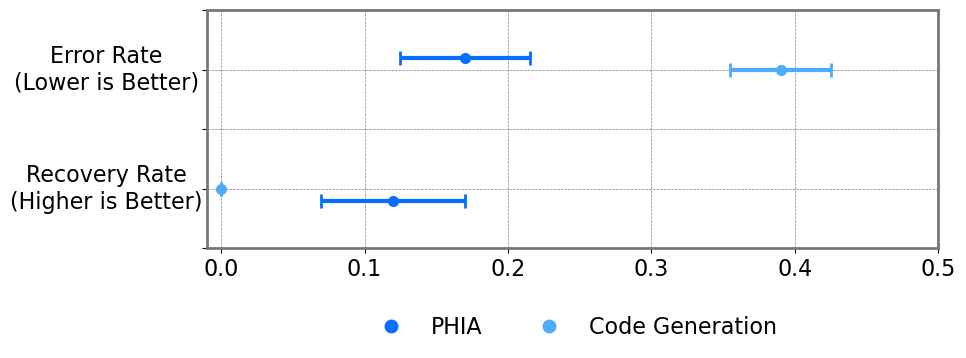

In [8]:


plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.edgecolor'] = "#777777"
plt.rcParams['axes.facecolor'] = '#FFFFFF'

MEDIUM_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

categories = ['Error Rate', 'Recovery Rate']
values_error_rate = [0.17, 0.39]
errors_error_rate = [0.045, 0.035]

values_recovery_rate = [0.12, 0]
errors_recovery_rate = [0.05, 0]

# Colors for each category
colors = ["#076EFF", "#4FABFF"]

# Creating the plot
fig, ax = plt.subplots(figsize=(10, 4))

# Adjusted y-coordinates for the categories
y_coords = np.array([2, 1])  # Base y-coordinates for categories

# Plot Error Rate
ax.errorbar(values_error_rate[0], y_coords[0]+0.1, xerr=errors_error_rate[0], fmt='o', capsize=5, color=colors[0], markeredgewidth=2, elinewidth=3)
ax.errorbar(values_error_rate[1], y_coords[0], xerr=errors_error_rate[1], fmt='o', capsize=5, color=colors[1], markeredgewidth=2, elinewidth=3)

# Plot Recovery Rate
ax.errorbar(values_recovery_rate[0], y_coords[1]-0.1, xerr=errors_recovery_rate[0], fmt='o', capsize=5, color=colors[0], markeredgewidth=2, elinewidth=3)
ax.errorbar(values_recovery_rate[1], y_coords[1], xerr=errors_recovery_rate[1], fmt='o', capsize=5, color=colors[1], markeredgewidth=2, elinewidth=3)

# Removing y-ticks
ax.set_yticklabels([])

# Adding grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, color='gray')

# Titles for the y-axis (subplots titles)
ax.text(-0.08, 2, 'Error Rate\n(Lower is Better)', ha='center', va='center', rotation=0, fontsize=MEDIUM_SIZE)
ax.text(-0.08, 1, 'Recovery Rate\n(Higher is Better)', ha='center', va='center', rotation=0, fontsize=MEDIUM_SIZE)

# Limiting x and y axes
ax.set_xlim(-0.01, 0.5)
ax.set_ylim(0.5, 2.5)

# Adding legends
handles = [
    plt.Line2D([0], [0], color=colors[0], marker='o', linestyle='None', markersize=8, markeredgewidth=2, label='PHIA'),
    plt.Line2D([0], [0], color=colors[1], marker='o', linestyle='None', markersize=8, markeredgewidth=2, label='Code Generation')
]
ax.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, frameon=False)
plt.tight_layout()
plt.savefig("./figs/6.pdf", bbox_inches='tight', format="pdf")
plt.show()
